This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Notes

## Tensorflow

本文講解了tf variable的基本運算，與一個簡單的線性分類問題。

先生成兩筆數據，賦予0, 1兩種數值。我們想找到一個線性方程分割兩種資料。對線性方程y = W*x+b而言，W和b是可以被訓練的變數(traiable)，我們就調整這兩項參數來找到最佳的方程。

我們設定的"model"就是y=W*x+b，而目的是左上角的資料被預測為-1，右下角的資料被預測為1。所以loss為預測值與原始值的差距。接著使用tf.GradientTape.gradient計算微分數值，乘上learning_rate後，就對W,b移動，直到loss為最小 (也就是梯度下降)。

經過多個epochs，loss逐漸下降穩定，此時W, b構成的線性方程，已經可以區分兩組數據群。

## Keras

keras是tensorflow的一個套件，提供簡單的一行指令配置模型，

先使用Sequential構建連續模型，在連接Dense, Simple Dense等運算層。接著使用Compile()來設定學習過程，如optimizer, learning_rate, loss, metrics等。最後使用Fit()來進行訓練，輸入inputs和targets，以及epochs和batch_size。

訓練完後使用Predict(x)可以進行預測，取得結果。

# Code

## First steps with TensorFlow

#### Constant tensors and variables

**All-ones or all-zeros tensors**

In [1]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [2]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


**Random tensors**

In [3]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[-0.8624291 ]
 [ 0.04830141]
 [ 0.970383  ]], shape=(3, 1), dtype=float32)


In [4]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.87161446]
 [0.40635753]
 [0.32536256]], shape=(3, 1), dtype=float32)


**NumPy arrays are assignable**

In [5]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

**Creating a TensorFlow variable**

In [6]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.612456  ],
       [ 0.06045781],
       [-1.0899807 ]], dtype=float32)>


**Assigning a value to a TensorFlow variable**

In [7]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Assigning a value to a subset of a TensorFlow variable**

In [8]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

**Using `assign_add`**

In [9]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### Tensor operations: Doing math in TensorFlow

**A few basic math operations**

In [10]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
e *= d

#### A second look at the GradientTape API

**Using the `GradientTape`**

In [11]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

**Using `GradientTape` with constant tensor inputs**

In [12]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

**Using nested gradient tapes to compute second-order gradients**

In [13]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

#### An end-to-end example: A linear classifier in pure TensorFlow

**Generating two classes of random points in a 2D plane**

In [14]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

**Stacking the two classes into an array with shape (2000, 2)**

In [15]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

**Generating the corresponding targets (0 and 1)**

In [16]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

**Plotting the two point classes**

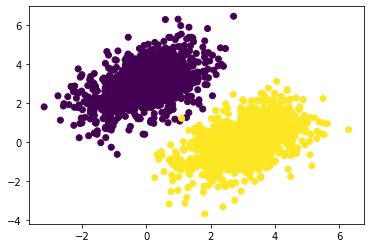

In [17]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creating the linear classifier variables**

In [18]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**The forward pass function**

In [19]:
def model(inputs):
    return tf.matmul(inputs, W) + b

**The mean squared error loss function**

In [20]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**The training step function**

In [21]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

**The batch training loop**

In [22]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 1.9043
Loss at step 1: 0.2660
Loss at step 2: 0.1224
Loss at step 3: 0.1004
Loss at step 4: 0.0926
Loss at step 5: 0.0868
Loss at step 6: 0.0816
Loss at step 7: 0.0769
Loss at step 8: 0.0726
Loss at step 9: 0.0686
Loss at step 10: 0.0650
Loss at step 11: 0.0617
Loss at step 12: 0.0586
Loss at step 13: 0.0558
Loss at step 14: 0.0532
Loss at step 15: 0.0509
Loss at step 16: 0.0487
Loss at step 17: 0.0467
Loss at step 18: 0.0449
Loss at step 19: 0.0433
Loss at step 20: 0.0417
Loss at step 21: 0.0403
Loss at step 22: 0.0391
Loss at step 23: 0.0379
Loss at step 24: 0.0368
Loss at step 25: 0.0358
Loss at step 26: 0.0349
Loss at step 27: 0.0341
Loss at step 28: 0.0333
Loss at step 29: 0.0326
Loss at step 30: 0.0320
Loss at step 31: 0.0314
Loss at step 32: 0.0308
Loss at step 33: 0.0304
Loss at step 34: 0.0299
Loss at step 35: 0.0295
Loss at step 36: 0.0291
Loss at step 37: 0.0288
Loss at step 38: 0.0284
Loss at step 39: 0.0281


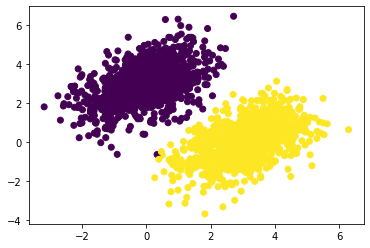

In [23]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

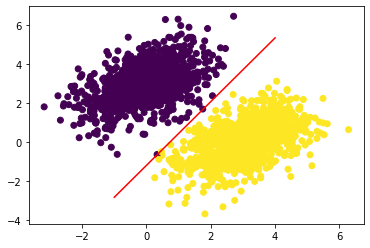

In [24]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomy of a neural network: Understanding core Keras APIs

### Layers: The building blocks of deep learning

#### The base Layer class in Keras

**A `Dense` layer implemented as a `Layer` subclass**

In [25]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

In [26]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


#### Automatic shape inference: Building layers on the fly

In [27]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

In [28]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

In [29]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

### From layers to models

### The "compile" step: Configuring the learning process

In [30]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [31]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### Picking a loss function

### Understanding the fit() method

**Calling `fit()` with NumPy data**

In [32]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 [==============================] - 1s 3ms/step - loss: 6.2338 - binary_accuracy: 0.4465
Epoch 2/5
16/16 [==============================] - 0s 3ms/step - loss: 5.8845 - binary_accuracy: 0.4435
Epoch 3/5
16/16 [==============================] - 0s 3ms/step - loss: 5.5942 - binary_accuracy: 0.4405
Epoch 4/5
16/16 [==============================] - 0s 3ms/step - loss: 5.3185 - binary_accuracy: 0.4385
Epoch 5/5
16/16 [==============================] - 0s 4ms/step - loss: 5.0527 - binary_accuracy: 0.4365


In [33]:
history.history

{'loss': [6.23380184173584,
  5.884521961212158,
  5.594208240509033,
  5.318536281585693,
  5.05270528793335],
 'binary_accuracy': [0.4465000033378601,
  0.44350001215934753,
  0.4404999911785126,
  0.43849998712539673,
  0.43650001287460327]}

### Monitoring loss and metrics on validation data

**Using the `validation_data` argument**

In [34]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 [==============================] - 1s 6ms/step - loss: 0.7887 - binary_accuracy: 0.8293 - val_loss: 0.0858 - val_binary_accuracy: 0.9250
Epoch 2/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0783 - binary_accuracy: 0.9493 - val_loss: 0.0779 - val_binary_accuracy: 0.9817
Epoch 3/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0691 - binary_accuracy: 0.9621 - val_loss: 0.0451 - val_binary_accuracy: 0.9983
Epoch 4/5
88/88 [==============================] - 0s 4ms/step - loss: 0.0681 - binary_accuracy: 0.9700 - val_loss: 0.0250 - val_binary_accuracy: 0.9983
Epoch 5/5
88/88 [==============================] - 0s 4ms/step - loss: 0.0714 - binary_accuracy: 0.9600 - val_loss: 0.0373 - val_binary_accuracy: 0.9967


### Inference: Using a model after training

In [35]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

[[-0.13382962]
 [ 0.82927346]
 [ 0.8753376 ]
 [ 0.01891592]
 [-0.06454352]
 [ 0.6271484 ]
 [ 0.07570764]
 [ 0.8678782 ]
 [ 0.5129897 ]
 [ 0.07112482]]
